# Business Understanding

This study is aimed at cryptocurrency price prediction using market bid/ask pressures within orderbook data collected from Kaiku.

**Guided walkthrough:**

When trading on a specific exchange there exists two differnet orders a trader can set:

1- **Market Orders:** These are orders that are settled immediately at the current market price.

    Example: BTC is trading at 9800USD setting a maket order of 0.2 BTC is settled immediately at a cost of (9800*0.2)1960USD in exchange for 0.2 BTC


2- **Limit Orders:** Include orders that are set to trigger at specific price levels to either buy/sell an asset.

    Example: BTC is trading at 9800USD setting a limit order of 0.2 BTC at 9700USD is settled when/if the price were to drop to 9700 at which the tranasction is settled at a cost of (9700*0.2)1940USD for 0.2 BTC

What is the current price?

-Sounds like a weird question to ask but in just in case. The current price is the least priced ask on the market when the trade is settled if you are a buyer. Otherwise, if you are a seller you would be selling at the highest bid at that time. 

Using the orderbook:
"The term order book refers to an electronic list of buy and sell orders for a specific security or financial instrument organized by price level. An order book lists the number of shares being bid on or offered at each price point, or market depth." https://www.investopedia.com/terms/o/order-book.asp

Using this data the prediction of the price movement can be monitored and predicted through changes in the orderbook reflecting buying support or selling resistance.
****

# Data Understanding

We will have a look at the data next
The data used was provided by Kaiku https://www.kaiko.com/

In [36]:
# Importing required dependancies 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import time
import bisect

In [37]:
data = pd.read_csv('Coinbase_BTCUSD_ob_10_2019_09_01.csv.gz', compression='gzip',error_bad_lines=False)
print("The structure of the dataframe is as follows:")
data

The structure of the dataframe is as follows:


date type     price    amount
0         1567296016662    b   9600.85  0.058399
1         1567296016662    b   9600.01  0.225000
2         1567296016662    b   9600.00  0.104123
3         1567296016662    b   9600.00  0.021774
4         1567296016662    b   9600.00  1.000000
...                 ...  ...       ...       ...
31007929  1567382368048    a  10743.20  0.004840
31007930  1567382368048    a  10744.40  0.001000
31007931  1567382368048    a  10745.00  0.001000
31007932  1567382368048    a  10745.46  0.001000
31007933  1567382368048    a  10747.00  1.000000

[31007934 rows x 4 columns]

The sample csv contains snapshots of the order book at different timestamps found within the column 'date'. The order is identified as either a bid or an ask within the 'type' column. The price and amount are also present in the remaining two columns.

The timestamp is in unix format with a millisecond accuracy.



**Investigating the timestamp values:**

There are 2861 unique timestamps
The timestamp difference is not consistent and varies from: 24.839s to 60.088s




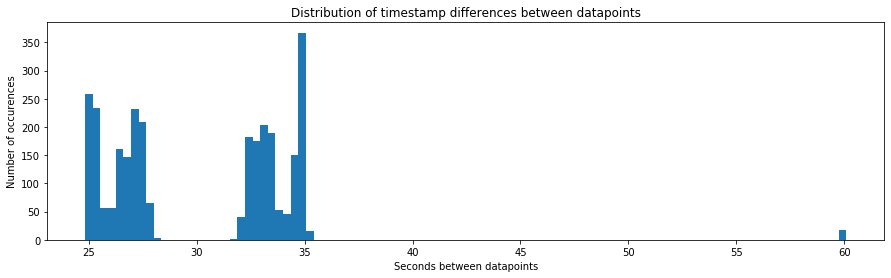

In [7]:
# Number of unique timestamps
print("There are {} unique timestamps".format(len(data['date'].unique())))

# Time difference between timestamps between entry points
a = [i for i,j in data.groupby("date")]
time_diff = np.diff(a) /1000
print("The timestamp difference is not consistent and varies from: {}s to {}s\n\n".format(time_diff.min(),time_diff.max()))

# Figure 
plt.figure(figsize=(15,4))
plt.hist(time_diff,100);
plt.title("Distribution of timestamp differences between datapoints")
plt.xlabel("Seconds between datapoints")
plt.ylabel("Number of occurences")
plt.show()

The dataset's timestamp frequency is not constant.

# Data Preperation

Rebinning the data 
Getting API data and save to data/files 

Importing Coinbase orderbook sample csv provided by Kaiko: https://www.kaiko.com/pages/cryptocurrency-data-types#6

**Plotting price chart:**

Maximum value: 9833.93 
Minimum value: 9545.36 
Starting value: 9600.855


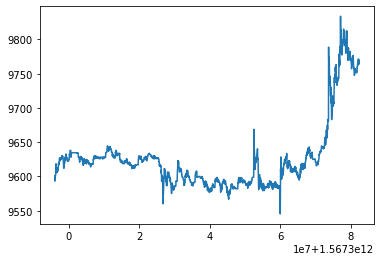

In [22]:
# Defining custom class:
class RevTypeCompares(object):
     def __init__(self, value):
         self.value = value
     def __gt__(self, other):
         return self.value < other[0:len(self.value)]
     def __lt__(self, other):
         return self.value[0:len(self.value)] > other
# Function that returns the average price based on the orderbook
def find_mid_price(i):
    """Takes the groupby 'date' dataframe and returns the mid_price between 
    the lowest ask and highest bid"""
    idx = bisect.bisect_left(list(i['type'].values), RevTypeCompares('a'))
    low = i['price'].values[0]
    high = i['price'].values[idx]

    return (low + high )/2
#__________________________________________

# Plotting the prices over the 24hr period
prices = []
for date, i in data.groupby("date"):
    mid_price =  find_mid_price(i)
    prices.append(round(mid_price,3))
    
print('Maximum value:',max(prices),'\nMinimum value:',min(prices),'\nStarting value:',prices[0])
plt.plot(data['date'].unique(),prices);

Since the orderbook data available is with a spectrum of 10% above and below the price visualising the data will need to be binned in ranges above and below the price.

**Manual data binning on first timestamp (Test Purposes):**

/Users/ranykhalil/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/ranykhalil/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


date type     price    amount  bins
0      1567296016662    b   9600.85  0.058399  1053
1      1567296016662    b   9600.01  0.225000  1052
2      1567296016662    b   9600.00  0.104123  1052
3      1567296016662    b   9600.00  0.021774  1052
4      1567296016662    b   9600.00  1.000000  1052
...              ...  ...       ...       ...   ...
10691  1567296016662    a  10560.00  0.015917   952
10692  1567296016662    a  10560.00  1.000000   952
10693  1567296016662    a  10560.00  0.009500   952
10694  1567296016662    a  10560.00  0.001000   952
10695  1567296016662    a  10560.00  0.001000   952

[10696 rows x 5 columns]

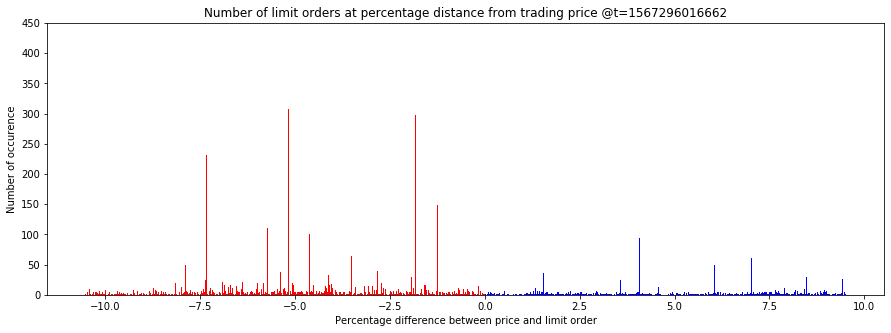

In [26]:
# Testing manual binning of bids/asks for first timestamp
data2 = data.loc[data['date'] == 1567296016662]
data3 = data2.loc[data2['type'] == 'b']
data4 = data2.loc[data2['type'] == 'a']

bid_bins,ask_bins = [],[]
bin_stepsize = 0.01/100 # 0.01 percent

value1, value2 = data3['price'].min(), data4['price'].min()

while value1 <=  data3['price'].max()*(1+bin_stepsize):
    bid_bins.append(value1)
    value1 = value1*(1+bin_stepsize)

labels = np.array(range(len(bid_bins)-1))
data3['bins'] = pd.cut(data3['price'],bid_bins,include_lowest=True,labels=labels);

while value2 <=  data4['price'].max()*(1+bin_stepsize):
    ask_bins.append(value2)
    value2 = value2*(1+bin_stepsize)

labels = np.array(range(len(ask_bins)-1))
data4['bins'] = pd.cut(data4['price'],ask_bins,include_lowest=True,labels=labels);

binned_data = pd.concat([data3,data4])

plt.figure(figsize=(15,5))
plt.hist(data3['bins'].map(lambda x: x*-0.01),data3['bins'].max(),color='red')
plt.hist(data4['bins'].map(lambda x: x*0.01),data4['bins'].max(),color='blue')

plt.title("Number of limit orders at percentage distance from trading price @t=1567296016662")
plt.xlabel("Percentage difference between price and limit order")
plt.ylabel("Number of occurence")
plt.ylim(0,450)
binned_data

Looking at the above graph it can be seen that there is a bit more pressure from the buy side at lower prices than there is from the sell side above the price hence reasonably we would expect the price to push higher.

Combining the last two figures we can see that the price visualised before did indeed move upward by 20-30USD following this timestamp

**Automated data binning on entire dataframe:**

In [32]:
# # Defining a function to return time spent on task 
# def time_checkpoint(n):
#     global start
#     diff = time.time() - start
#     start = time.time()
#     print(n, ":", diff)

# Binning data into wider format
# N = 1000 #Number of bins in bid/ask range --> 10%/1000 --> 0.01% bin size

# cols, newdf = create_newdf(N)

# start = time.time()


# for date, i in data.groupby("date"):
#     mid_price =  find_mid_price(i)
#     low = mid_price * 0.9
#     high = mid_price * 1.1
    
#     next_row = list(np.zeros(N * 2))
        
#     for ii, j in i.iterrows():
#         b = math.floor( (j["price"] - low ) / ( high - low  ) * N * 2 )
#         if b >= 2 * N or b < 0:
#             continue
#         next_row[b] += j["amount"]
#     newdf.loc[date] = pd.Series([date] + next_row, index=cols)
#     time_checkpoint(date)

# newdf.to_csv('binned_data_24hrs.csv',header=True)
newdf = pd.read_csv('binned_data_24hrs.csv')
newdf.set_index('date',drop=True,inplace=True)
newdf.T.iloc[::-1]

date  1567296016662  1567296049570  1567296076678  1567296109569  \
1999       1.027417       0.001000       0.003000       0.003000   
1998       0.010289       0.000000       0.302000       0.302000   
1997       0.003000      14.718723       1.544140       1.544140   
1996       0.302000       0.034335       0.014926       0.014926   
1995       1.544140       3.554217       1.960000       1.960000   
...             ...            ...            ...            ...   
4          0.001000       0.000000       0.005785       0.060785   
3          0.300000      12.105388       0.055000       0.000000   
2          0.060785       0.031548       0.085643       0.085643   
1          0.085643       0.411790       0.150000       0.150000   
0          0.150000       0.000000       1.052499       1.052499   

date  1567296136677  1567296169574  1567296196712  1567296229569  \
1999       0.010289       1.037706       1.027417       0.000000   
1998       0.003000       0.003000       0.010289       1.037706   
1997       0.302000       0.302000       0.003000       0.003000   
1996       1.544140       1.544140       0.302000       0.302000   
1995       0.014926       0.014926       1.544140       1.544140   
...             ...            ...            ...            ...   
4          0.300000       0.300000       0.001000       0.001000   
3          0.060785       0.005785       0.300000       0.300000   
2          0.085643       0.055000       0.060785       0.060785   
1          0.150000       0.085643       0.085643       0.085643   
0          1.052499       0.150000       0.150000       0.150000   

date  1567296256690  1567296289569  ...  1567382101467  1567382127936  \
1999       0.001000       1.000000  ...       0.001000      46.120000   
1998       0.000000       0.003000  ...       0.004840       1.000000   
1997       0.050000       0.000000  ...       0.006000       0.000000   
1996       0.000000       0.002000  ...       1.050000       0.002000   
1995       0.310503       0.003200  ...       0.631749       0.001000   
...             ...            ...  ...            ...            ...   
4          0.028868       0.000000  ...       0.600000       0.150000   
3          0.000000      10.040388  ...       0.677529       0.100000   
2          1.469388       0.896393  ...       0.005000       0.123000   
1          0.000000       0.295063  ...       0.100000       0.600000   
0          0.021000      47.950509  ...       0.001000       0.677529   

date  1567382161493  1567382187935  1567382221495  1567382248045  \
1999       1.000000       0.028560       0.001000       1.050000   
1998       0.001000       0.172911       0.010840       0.631749   
1997       0.002000       0.000000       0.050000       0.079560   
1996       0.004840       0.046642       1.000000       0.172911   
1995       0.006000       1.302200       0.631749       0.000000   
...             ...            ...            ...            ...   
4          0.123000       0.011300       0.677529       0.000000   
3          0.600000       4.713970       0.005000       0.101000   
2          0.677529       0.353350       0.000000       0.011300   
1          0.005000       1.166026       0.100000       4.713970   
0          0.000000       0.347475       0.001000       0.353350   

date  1567382281511  1567382308031  1567382341505  1567382368048  
1999       1.050000       0.050000       0.002000       0.000000  
1998       0.000000       1.000000       0.001000       0.001000  
1997       0.711309       0.682749       0.009840       0.002000  
1996       0.172911       0.028560       0.051000       0.004840  
1995       0.000000       0.172911       1.000000       0.006000  
...             ...            ...            ...            ...  
4          0.000000       0.000000       0.600000       0.123000  
3          0.100000       0.100000       0.677529       0.600000  
2          0.001000       0.001000       0.005000       0.677529  
1 

Data has now been reshaped into binned aggregates of order amounts at price bins identified by the column numbers.

**For Columns 0-999 (bid):**
Column X is the amount of BTC placed in the orderbook that are priced at (1000-X)*0.01% away from the current price for the given timestamp.

**For Columns 1000-1999 (ask):**
Column X is the amount of BTC placed in the orderbook that are priced at (X-999)*0.01% away from the current price for the given timestamp.

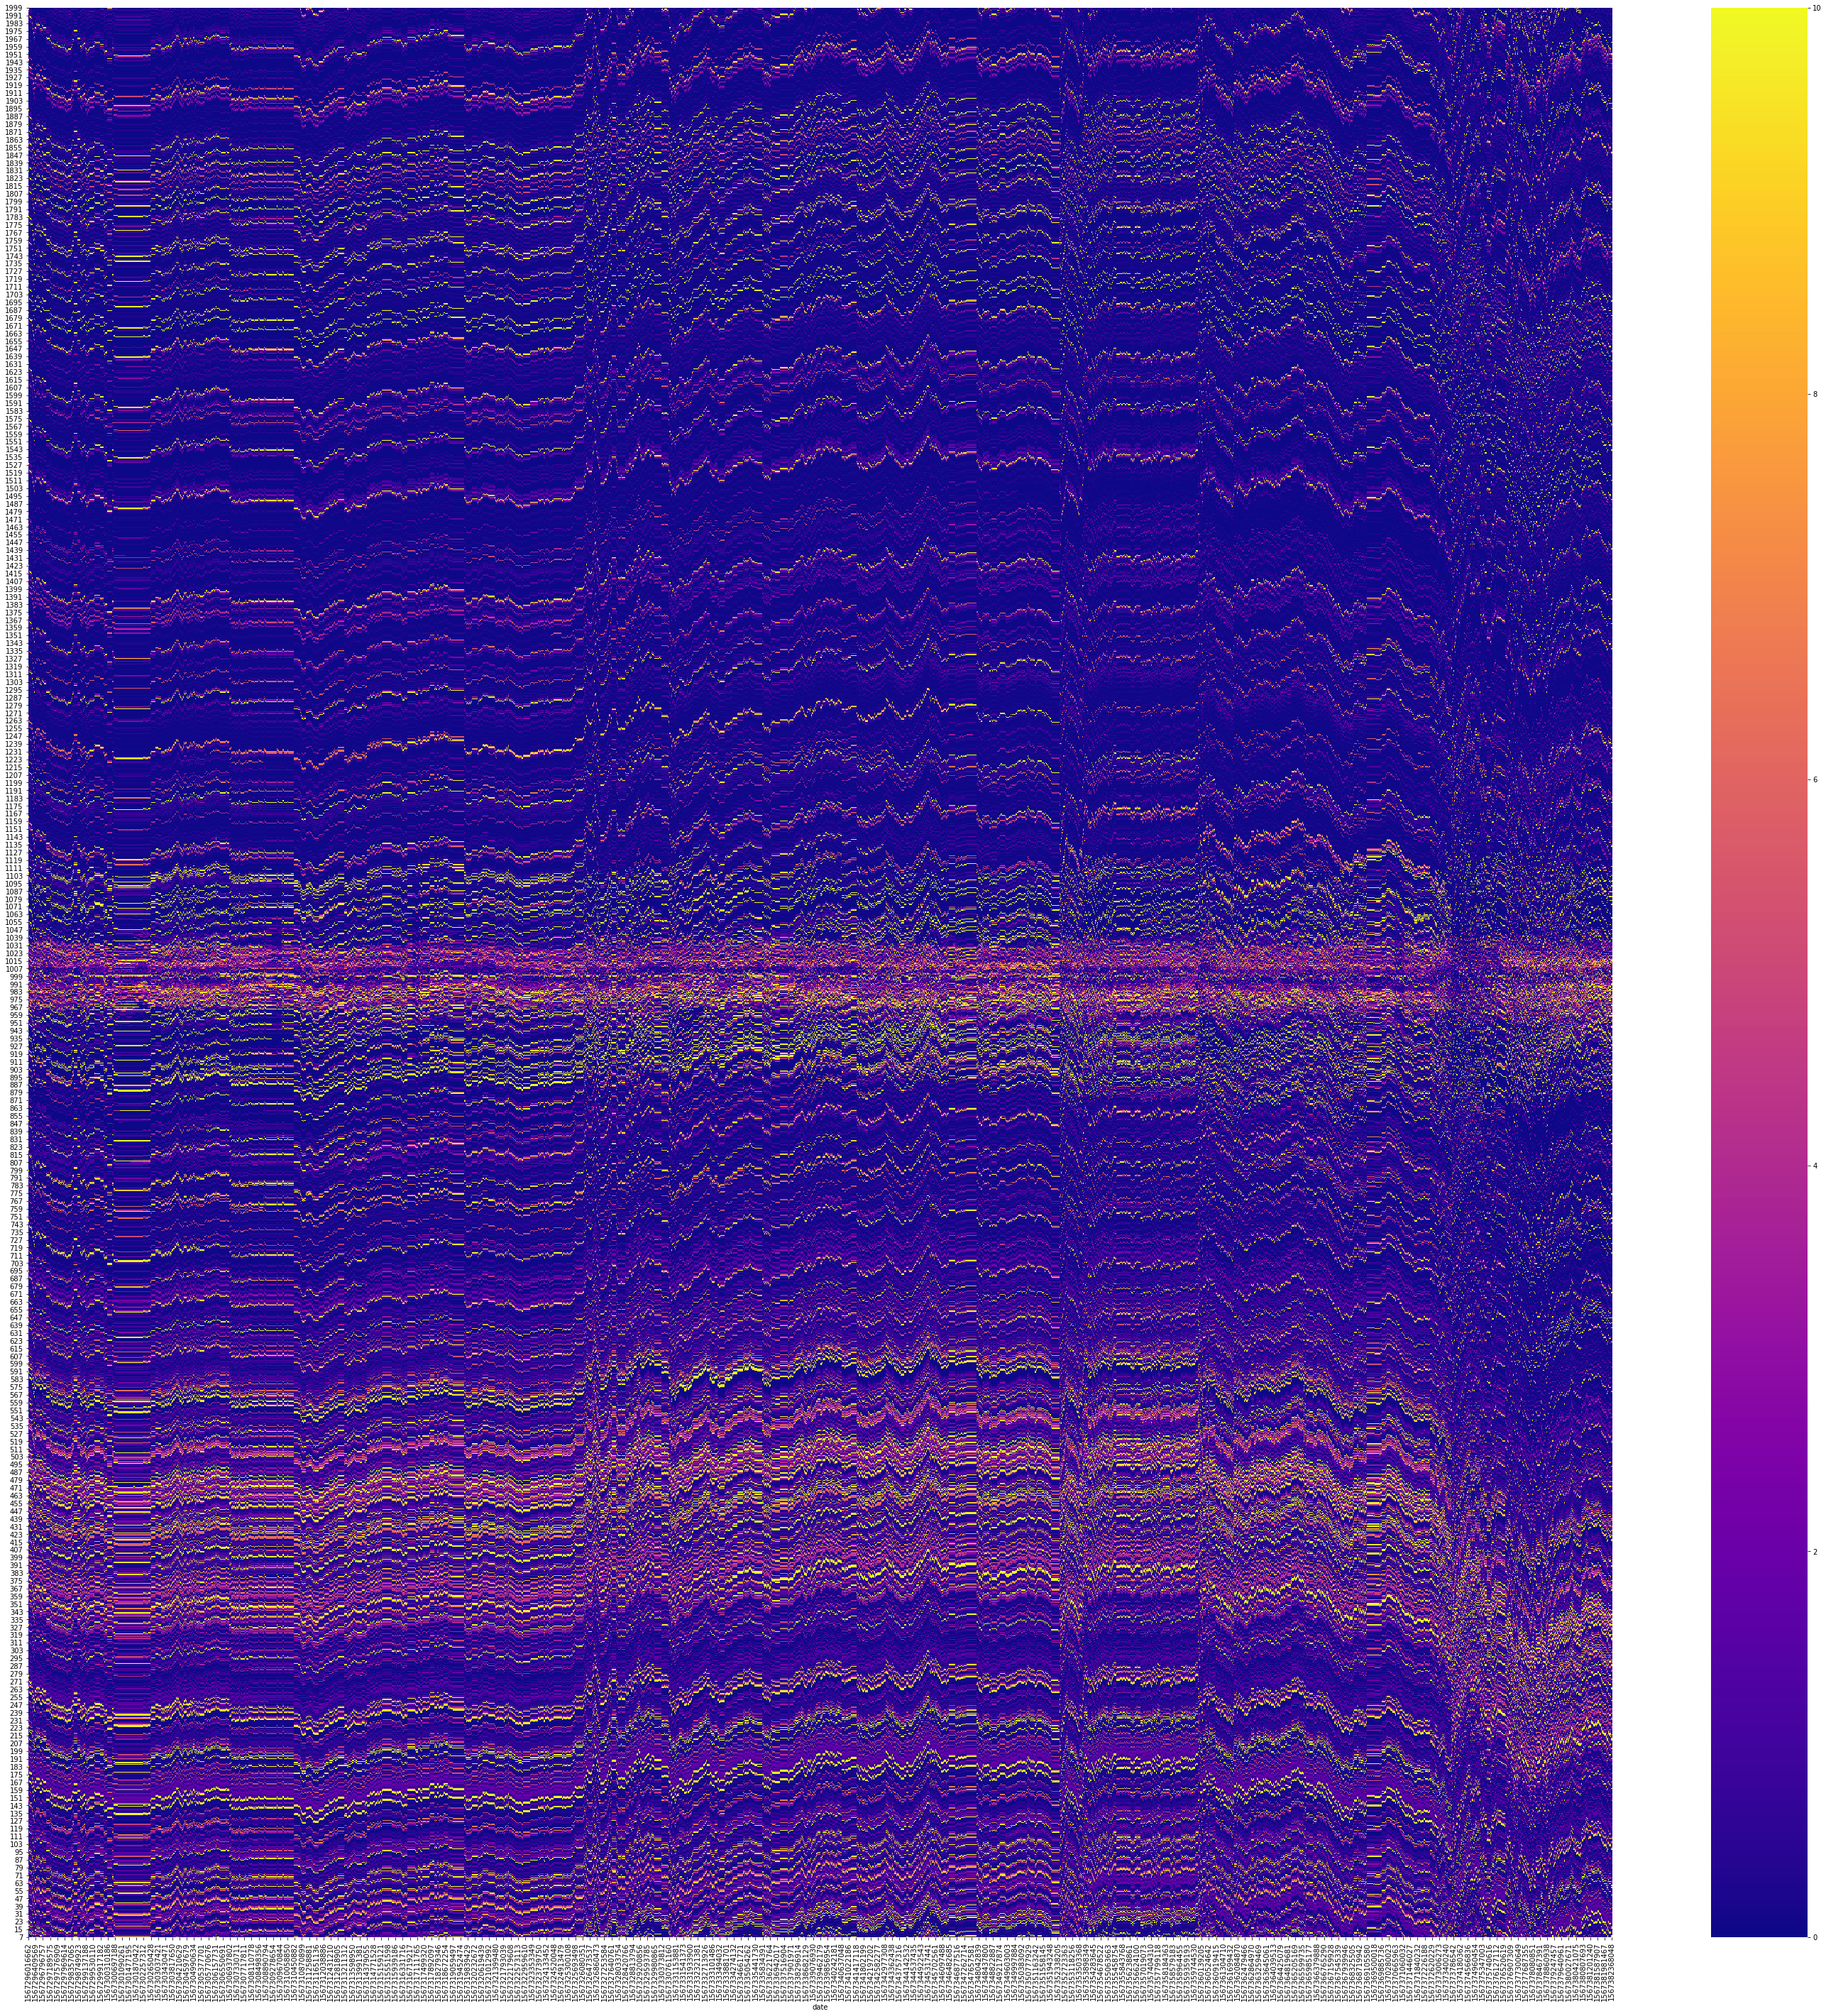

In [38]:
plt.figure(figsize=(50,50))
sns.heatmap(newdf.T.iloc[::-1],vmin=0,vmax=10,cmap="plasma")

The chart above plots the differnet bins above and below the current price (The x-axis is time, while the y-axis is the different bins in which the prices are allocated to). Since all values here are represented in terms of a percentage to the price the current price can be considered to be the horizontal line drawn through the middel of the figure.